This notebook explores the relationship between rate distortion and privacy.

First, some preliminaries:

In [3]:
:set -XRebindableSyntax
:set -XNoImplicitPrelude

import Privacy.Prelude

We'll need some random variables:

In [1]:
import System.Random
import Statistics.Distribution.Normal
import System.Random.MWC
import Statistics.Distribution
import Graphics.Rendering.Chart.Plot.Histogram.Simple
import Control.Monad



We can build a huffman tree from these variables:

In [6]:
import Algebra.Information.Huffman
import Algebra.Information.Tree
import qualified Data.List.NonEmpty as NonEmpty
import Data.Functor.Contravariant
import Data.Bifunctor
import Data.Monoid
import qualified Data.Map.Strict as Map
import Algebra.Information.Huffman.Alphabetic

ages :: [(Rational, Int)]
ages = (fmap.first) (4.5+)
     [ ( 0, 7)
     , (10,13)
     , (20,14)
     , (30,25)
     , (40,20)
     , (50,12)
     , (60, 7)
     , (70, 2) ]

:opt svg

tree
    = first getSum
    . huffmanTree defaultComparison (const (Sum 1)) 
    . NonEmpty.fromList 

agesTree = tree (ages >>= uncurry (flip replicate))
alphAgesTree = alphHuffman ages

import Data.List (sort)

weightedMedian :: (Num a, Fractional a, Ord a) => [(a,Int)] -> a
weightedMedian xs = med (sort (xs >>= uncurry (flip replicate)))
  where
    med xs
      | even ln = ((xs !! (n-1)) + (xs !! n)) / 2
      | otherwise = xs !! n
      where
        ln = length xs
        n = ln `div` 2

withVals :: Tree a b -> [(b,a)]
withVals (Leaf x y) = [(y,x)]
withVals (Node _ l r) = withVals l ++ withVals r

medianHide :: (Ord a, Fractional a) => Int -> Tree Int a -> Tree Int a
medianHide k tr@(Node n l r)
    | measure l < k || measure r < k = Leaf n (weightedMedian (withVals tr))
    | otherwise = Node n (medianHide k l) (medianHide k r)
medianHide _ tr = tr

mse x y = let z = (x-y) in z*z

cb = codeBook agesTree

wavg xs = sum (map (\(x,y) -> x * fromIntegral y) xs) / fromIntegral (sum (map snd xs))

kenc k = wavg $ (fmap.first) (\x -> mse (either val id (followPath (cb Map.! x) tr)) x  ) ages
  where
    tr = medianHide k agesTree
    
--agesTree

:set -XStandaloneDeriving

deriving instance (Show a, Show b) => Show (Tree a b)

print alphAgesTree

-- import Data.List (groupBy)

-- mapM_ print $ map (first (fromRational :: Rational -> Double)) $ map last $ groupBy (\(x,_) (y,_) -> x == y) $ zip (map (`kdistortion` alphAgesTree) [100,99..0]) [0..]


Node {measure = 100, lchild = Node {measure = 59, lchild = Node {measure = 34, lchild = Node {measure = 20, lchild = Leaf {measure = 7, val = 9 % 2}, rchild = Leaf {measure = 13, val = 29 % 2}}, rchild = Leaf {measure = 14, val = 49 % 2}}, rchild = Leaf {measure = 25, val = 69 % 2}}, rchild = Node {measure = 41, lchild = Leaf {measure = 20, val = 89 % 2}, rchild = Node {measure = 21, lchild = Leaf {measure = 12, val = 109 % 2}, rchild = Node {measure = 9, lchild = Leaf {measure = 7, val = 129 % 2}, rchild = Leaf {measure = 2, val = 149 % 2}}}}}

For $k$-anonymity, we cut off revealing the tree at a certain point. Below that point, we simply return a summary of the subtree.

We can see what value of $k$ is provided after cutting off at a certain level by taking the minimum size of subtrees at that level:

In [14]:
import Algebra.Information.Tree

rates tree

[1000,409,187,89,41,20,10,4,2,2,1]

We can plot that $k$ against the number of bits revealed

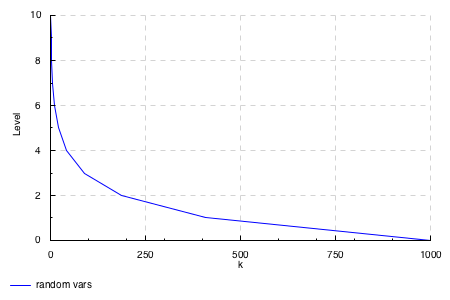

In [16]:
import Graphics.Rendering.Chart.Plot.Lines
import Graphics.Rendering.Chart.Plot
import Graphics.Rendering.Chart.Layout
import Graphics.Rendering.Chart (toRenderable)
import Control.Lens ((.~))
import Data.Default


plotRateDistortion xs
    = toRenderable
    $ layout_plots .~ [ toPlot
                      $ PlotLines
                          "random vars"
                          defaultPlotLineStyle
                          [zip xs [0..]]
                          []
                      ]
    $ layout_x_axis.laxis_title .~ "k"
    $ layout_y_axis.laxis_title .~ "Level"
    $ def

plotRateDistortion (rates tree)

In [34]:
:ext FlexibleContexts

import           Control.Monad.State
import qualified Data.Map.Strict     as Map
import           Data.Foldable       (Foldable(..))
import           Algebra.Information.Huffman.Alphabetic (optAlphTree)
import           Data.Bifunctor (first)

buildAlphHuffman :: Histogram Count a -> Tree Count a
buildAlphHuffman xs = evalState (go c) (Map.toList (getHistogram xs))
  where
    c = fromEnum (sum (getCount <#$> getHistogram xs))
    go n = do
      (x,Count i) <- gets head
      if fromEnum i >= n
        then do
          modify tail
          pure (Leaf (Count i) x)
        else do
          let m = n `div` 2
          ls <- go m
          let nxt = n - fromEnum (getCount (measure ls))
          if nxt <= 0 then pure ls else do
            rs <- go nxt
            pure (Node (measure ls <> measure rs) ls rs)
            
buildOptAlphHuffman :: Ord a => Histogram Count a -> Tree Count a
buildOptAlphHuffman xs
    = first (Count . toEnum) 
    $ optAlphTree
    [ (fromEnum i, x)
    | (x,Count i) <- Map.toList (getHistogram xs) ]

alphHuffmanTree :: (Foldable1 f, Ord a) => f a -> Tree Count a
alphHuffmanTree = buildAlphHuffman . generalizeTo (histogramOf count)

<interactive>:1:1: error:
    Could not find module ‘Algebra.Information.Huffman.Alphabetic’
    Use -v to see a list of the files searched for.